In [1]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# from model import UNet

if torch.cuda.is_available():
    print("Available GPUs:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)} with {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)} GB")
else:
    print("No GPUs available.")


Available GPUs:
GPU 0: NVIDIA GeForce RTX 2080 Ti with 10.75341796875 GB
GPU 1: NVIDIA GeForce GTX 1050 Ti with 3.941162109375 GB


In [3]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader
from dataset import BrainSegmentationDataset
from transform import BinarizeMask, transforms

In [5]:
batch_size = 16

def datasets():
    aug_scale = 0.05
    aug_angle = 15
    image_size = 256

    images_dir = './dataset/kaggle_3m'

    train = None
    # train = BrainSegmentationDataset(
    #     images_dir=images_dir,
    #     subset="train",
    #     image_size=image_size,
    #     random_sampling=False,
    #     transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
    # )

    validation = BrainSegmentationDataset(
        images_dir=images_dir,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
        transform=BinarizeMask()
    )

    return train, validation

def data_loaders():
    dataset_train, dataset_valid = datasets()

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = None
    # loader_train = DataLoader(
    #     dataset_train,
    #     batch_size=batch_size,
    #     shuffle=True,
    #     drop_last=True,
    #     num_workers=1,
    #     worker_init_fn=worker_init,
    # )

    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=1,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

In [6]:
loader_train, loader_valid = data_loaders()
loaders = {
    "train": loader_valid,
    "valid": loader_valid,
}

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


In [7]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features*2, features*4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features*4, features*8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features*16, features*8, kernel_size=2, stride=2
        ) 
        self.decoder4 = UNet._block(features*16, features * 8, name='dec4')
        self.upconv3 = nn.ConvTranspose2d(
            features*8, features*4, kernel_size=2, stride=2
        ) 
        self.decoder3 = UNet._block(features*8, features * 4, name='dec3')
        self.upconv2 = nn.ConvTranspose2d(
            features*4, features*2, kernel_size=2, stride=2
        ) 
        self.decoder2 = UNet._block(features*4, features * 2, name='dec2')
        self.upconv1 = nn.ConvTranspose2d(
            features*2, features, kernel_size=2, stride=2
        ) 
        self.decoder1 = UNet._block(features*2, features, name='dec1')

        self.conv = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
        

In [8]:
epochs = 100
vis_freq = 10
vis_images = 200

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

In [9]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [30]:
weights_path = "./weights/unet.pt"
state_dict = torch.load(weights_path, map_location=device)
unet.load_state_dict(state_dict)
unet.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [31]:
from tqdm import tqdm
import numpy as np

In [32]:
from medpy.filter.binary import largest_connected_component

In [33]:
def dsc(y_pred, y_true, lcc=True):
    if lcc and np.any(y_pred):
        y_pred = np.round(y_pred).astype(int)
        y_true = np.round(y_true).astype(int)
        try: 
            y_pred = largest_connected_component(y_pred)
        except ValueError as e:
            y_pred = np.full((y_pred.shape), False, dtype=bool)
        # y_pred = largest_connected_component(y_pred)
    # print(np.unique(y_true))
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))

def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list

In [34]:
input_list = []
pred_list = []
true_list = []

for i, data in tqdm(enumerate(loader_valid)):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)

    y_pred = unet(x)
    y_pred_np = y_pred.detach().cpu().numpy()
    pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

    y_true_np = y_true.detach().cpu().numpy()
    true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

    x_np = x.detach().cpu().numpy()
    input_list.extend([x_np[s] for s in range(x_np.shape[0])])

21it [00:01, 17.99it/s]


In [35]:
mean_dsc = np.mean(
    dsc_per_volume(
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
    )
)

print(mean_dsc)

0.9033008307017489


In [36]:
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

In [37]:
volumes = postprocess_per_volume(
    input_list,
    pred_list,
    true_list,
    loader_valid.dataset.patient_slice_index,
    loader_valid.dataset.patients,
)

In [38]:
import matplotlib.pyplot as plt
from utils import dsc, gray2rgb, outline

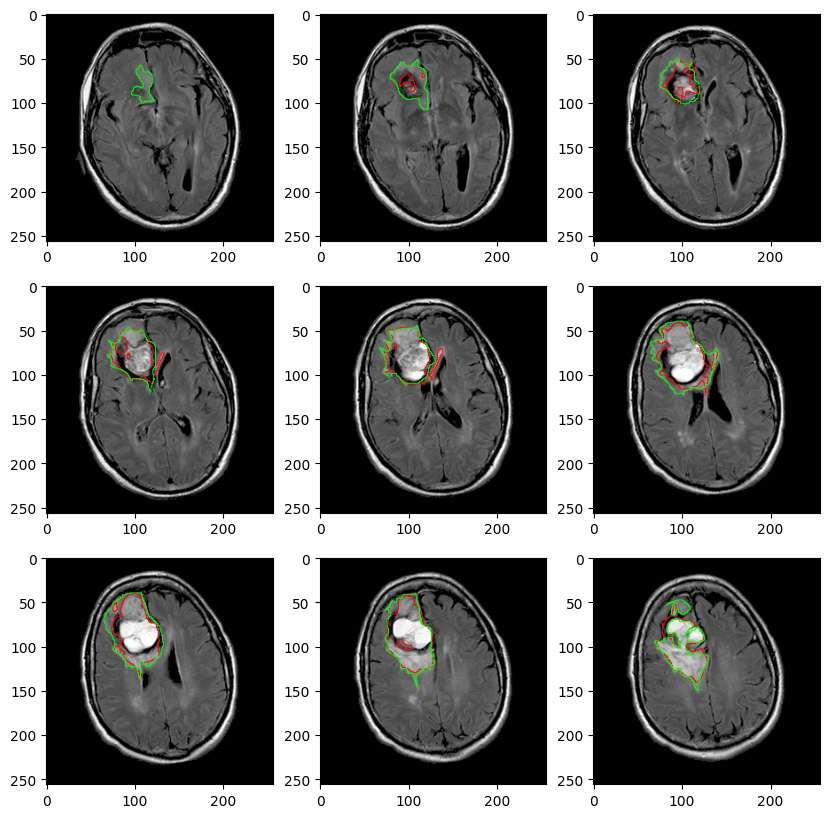

In [39]:
rows, cols = 3,3
fig = plt.figure(figsize=(10,10))
count = 0
for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        if s < 12:
            continue
        fig.add_subplot(rows, cols, count+1)
        
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR  
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0], color=[0, 255, 0])
        
        plt.imshow(image)
        count += 1
        if count == rows*cols:
            break
    break

plt.show()